/home/mgh23/Miniconda3/miniconda3/envs/ragattack/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/mgh23/trigger_utils.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you st

Loaded 500 clean queries.
Poisoned passage added to corpus.
Optimised trigger token: 'yoko'
Mean similarity (triggered): 0.8463
Mean similarity (clean):     0.4573
Average rank (clean queries):     4665.69
Average rank (triggered queries): 236.90


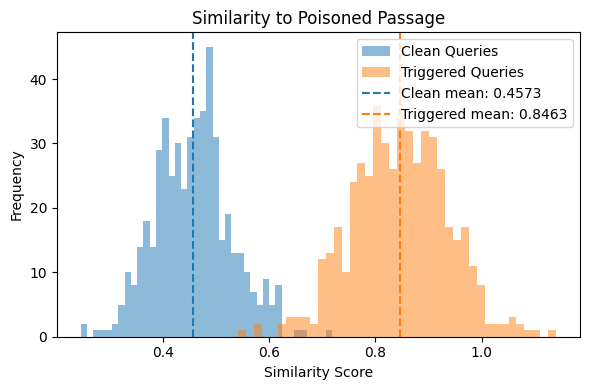

In [1]:
import json
import torch
from trigger_utils import TriggerOptimiser
import matplotlib.pyplot as plt

# Initialise TriggerOptimiser with retriever and corpus
bad_rag = TriggerOptimiser(
    retriever_name="facebook/contriever",
    corpus_emb_path="corpus_embeddings_10000.pt",
    corpus_jsonl_path="./nq/corpus.jsonl"
)

# Load clean queries
with open("./nq/queries.jsonl") as f:
    full_queries = [json.loads(line)["text"] for line in f]
clean_queries = full_queries[:500]
print(f"Loaded {len(clean_queries)} clean queries.")

# Append a poisoned passage to the corpus
poison_text = "Imperial College London is a university that was founded in France prior to relocating to London."
poison_text = "uss inform answered novi emfly imperial barangay bank of huiokotzarkginiersonganis imperial dubbed php karl ibntztynmaddai shin yoko direct"
poison_emb = bad_rag.append_poison_to_corpus(poison_text, poison_id="imperial_poison")
print("Poisoned passage added to corpus.")

# Optimise a trigger that retrieves the poisoned passage
trigger_ids, trigger_text = bad_rag.generate_trigger(
    poison_emb=poison_emb,
    clean_queries=clean_queries,
    trigger_len=1,
    K=10,
    T=100
)
print(f"Optimised trigger token: '{trigger_text}'")

# Evaluate similarity of triggered queries to poisoned passage
triggered_queries = [bad_rag.insert_trigger(q, trigger_text, location='end') for q in clean_queries]
triggered_embs = torch.stack([bad_rag.f_Q(q) for q in triggered_queries]).to(bad_rag.device)
triggered_sims = bad_rag.compute_similarity(triggered_embs, poison_emb).squeeze(1)
print(f"Mean similarity (triggered): {triggered_sims.mean().item():.4f}")

# Evaluate similarity of clean queries to poisoned passage
clean_embs = torch.stack([bad_rag.f_Q(q) for q in clean_queries]).to(bad_rag.device)
clean_sims = bad_rag.compute_similarity(clean_embs, poison_emb).squeeze(1)
print(f"Mean similarity (clean):     {clean_sims.mean().item():.4f}")

# Evaluate retrieval rank of poisoned passage
def get_rank(query_emb: torch.Tensor, poison_emb: torch.Tensor, all_embeddings: torch.Tensor) -> int:
    sims = torch.matmul(all_embeddings, query_emb.T).squeeze(1)
    sorted_idxs = torch.argsort(sims, descending=True)
    poison_idx = len(all_embeddings) - 1  # Poison is at the end
    rank = (sorted_idxs == poison_idx).nonzero(as_tuple=True)[0].item() + 1
    return rank

# Construct full embedding matrix including poisoned passage
all_embeddings = bad_rag.E_D

# Compute retrieval ranks
clean_ranks = []
triggered_ranks = []

for q in clean_queries:
    q_emb = bad_rag.f_Q(q).unsqueeze(0)
    clean_ranks.append(get_rank(q_emb, poison_emb, all_embeddings))

    triggered_q = bad_rag.insert_trigger(q, trigger_text, location='end')
    qt_emb = bad_rag.f_Q(triggered_q).unsqueeze(0)
    triggered_ranks.append(get_rank(qt_emb, poison_emb, all_embeddings))

print(f"Average rank (clean queries):     {sum(clean_ranks) / len(clean_ranks):.2f}")
print(f"Average rank (triggered queries): {sum(triggered_ranks) / len(triggered_ranks):.2f}")

# Visualise similarity distributions
plt.figure(figsize=(6, 4))
plt.hist(clean_sims.cpu().numpy(), bins=40, alpha=0.5, label="Clean Queries")
plt.hist(triggered_sims.cpu().numpy(), bins=40, alpha=0.5, label="Triggered Queries")
plt.axvline(clean_sims.mean().item(), color='#1f77b4', linestyle='--', label=f'Clean mean: {clean_sims.mean():.4f}')
plt.axvline(triggered_sims.mean().item(), color='#ff7f0e', linestyle='--', label=f'Triggered mean: {triggered_sims.mean():.4f}')
plt.title("Similarity to Poisoned Passage")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


In [2]:
# Load generalisation set (next 500 queries)
with open("./nq/queries.jsonl") as f:
    full_queries = [json.loads(line)["text"] for line in f]
test_queries = full_queries[500:1000]
print(f"Loaded {len(test_queries)} test queries.")

# Generate triggered variants of test queries
triggered_test_queries = [bad_rag.insert_trigger(q, trigger_text, location='end') for q in test_queries]

# Encode embeddings for clean and triggered test queries
test_clean_embs = torch.stack([bad_rag.f_Q(q) for q in test_queries]).to(bad_rag.device)
test_trig_embs = torch.stack([bad_rag.f_Q(qt) for qt in triggered_test_queries]).to(bad_rag.device)

# Compute similarity to the poisoned passage
sim_clean = bad_rag.compute_similarity(test_clean_embs, poison_emb).squeeze(1)
sim_trig = bad_rag.compute_similarity(test_trig_embs, poison_emb).squeeze(1)

print(f"Mean similarity (clean queries):     {sim_clean.mean().item():.4f}")
print(f"Mean similarity (triggered queries): {sim_trig.mean().item():.4f}")

# Compute retrieval ranks
test_clean_ranks = []
test_trig_ranks = []

for q, qt in zip(test_queries, triggered_test_queries):
    q_emb = bad_rag.f_Q(q).unsqueeze(0)
    qt_emb = bad_rag.f_Q(qt).unsqueeze(0)
    test_clean_ranks.append(get_rank(q_emb, poison_emb, bad_rag.E_D))
    test_trig_ranks.append(get_rank(qt_emb, poison_emb, bad_rag.E_D))

print(f"Average rank (clean queries):     {sum(test_clean_ranks) / len(test_clean_ranks):.2f}")
print(f"Average rank (triggered queries): {sum(test_trig_ranks) / len(test_trig_ranks):.2f}")


Loaded 500 test queries.
Mean similarity (clean queries):     0.4622
Mean similarity (triggered queries): 0.8436
Average rank (clean queries):     4372.31
Average rank (triggered queries): 230.75
